In [1]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# PytorchでNNモデルを作成して、学習する手順

## やること
### 1. データの読み込み
### 2. モデルの作成
### 3. 学習
### 4. 評価
### 5. モデルの保存
### 6. 検証

# 1. データの読み込み

## 使うライブラリ
- torch.utils.data.Dataset()
- torch.utils.data.DataLoader()


In [2]:
digits = load_digits()

In [3]:
X = digits.data
y = digits.target

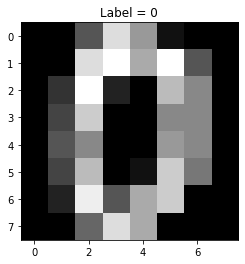

In [4]:
plt.title(f"Label = {y[0]}")
plt.imshow(X[0].reshape(8,8), cmap="gray")
plt.show()

In [5]:
#学習用データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [7]:
#==== train ====
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)

#==== validation
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.int64)

#==== test ====
X_test = torch.tensor(X_test, dtype=torch.float32)

In [8]:
#==== 学習用(train) ====
ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(ds, batch_size=32, shuffle=True)

#==== 検証用(valid) ====
ds = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(ds, batch_size=32, shuffle=True)

#==== テスト用(test) ====
ds = TensorDataset(X_test)
test_loader = DataLoader(ds, batch_size=1, shuffle=False)

torch.Size([32, 64])
tensor(4)


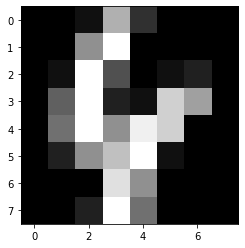

In [9]:
for train, val in train_loader:
    print(train.shape)
    print(val[0])
    plt.imshow(train[0].reshape(8,8), cmap="gray")
    plt.show()
    break

# 2. モデル作成

## 使うライブラリ
- torch.nn.Module
- torch.nn



In [10]:
class NNNet(nn.Module):
    
    def __init__(self, in_features, num_class=10):
        super(NNNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, num_class)
        )
        
    def forward(self, x):
        out = self.net(x)
        
        return out
        
        

# 学習

## 使うもの
- 損失関数(LossFunction)
 - torch.nn.CrossEntropyLoss()
- 最適化関数(Optimizer)
 - torch.optim.Adam(model.paraters(), lr=learning_rate)
 
- デバイス選択
 to

## 手順
1. deviceの選択
- モデルの定義
- 損失関数の定義
- Optimizerの定義
- データをdeviceに渡す
- Optimizerの初期化
- forward(処理ネットワークにデータを入力)
- Lossを計算(損失関数に渡す)
- backward(loss.backward())
- Optimizerを更新(optimizer.step())

In [11]:
#==== deviceの選択 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#==== モデルの定義 ====
model = NNNet(64).to(device)

#==== 損失関数の定義 ====
criterion = nn.CrossEntropyLoss()

#==== Optimizerの定義 ====
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
#==== 学習 ====
def learning(train_loader, val_loader, num_epochs=100):
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        valid_loss = 0
        valid_acc = 0
        
        
        #==== 学習 ====
        model.train()
        
        for images, labels in train_loader:
            #==== deviceに渡す
            images = images.to(device)
            labels = labels.to(device)
            
            #==== Optimizerの初期化 ====
            optimizer.zero_grad()
            
            #==== forward processing ====
            outputs = model(images)
            
            #==== Loss calcuration ====
            loss = criterion(outputs, labels)
            
            #==== backward processing ====
            loss.backward()
            
            #==== update optimizer ====
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += (outputs.max(1)[1] == labels).sum().item()
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_acc / len(train_loader.dataset)
        
        #==== 検証 =====
        model.eval()
        
        #重みを変えさせない
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                valid_acc += (outputs.max(1)[1] == labels).sum().item()
                
        avg_valid_loss = valid_loss / len(valid_loader.dataset)
        avg_valid_acc = valid_acc / len(valid_loader.dataset)
        
        print(f"=====  epoch: {epoch+1} ===== \
        \n train_loss: {avg_train_loss}, valid_loss: {avg_valid_loss} \
        \n train_acc: {avg_train_acc}, valid_acc: {avg_valid_acc}")
        
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        valid_loss_list.append(avg_valid_loss)
        valid_acc_list.append(avg_valid_acc)
        
    loss_list = [train_loss_list, valid_loss_list]
    acc_list = [train_acc_list, valid_acc_list]
    
    return loss_list, acc_list

In [13]:
loss_list, acc_list = learning(train_loader, valid_loader)

=====  epoch: 1 =====         
 train_loss: 0.028541882402861297, valid_loss: 0.011163744609802961         
 train_acc: 0.7064676616915423, valid_acc: 0.8912037037037037
=====  epoch: 2 =====         
 train_loss: 0.007897409722579652, valid_loss: 0.008232864042468093         
 train_acc: 0.9203980099502488, valid_acc: 0.9212962962962963
=====  epoch: 3 =====         
 train_loss: 0.005914402986640361, valid_loss: 0.0049184791364327626         
 train_acc: 0.9333333333333333, valid_acc: 0.9583333333333334
=====  epoch: 4 =====         
 train_loss: 0.002960781818626458, valid_loss: 0.005172873243551563         
 train_acc: 0.9691542288557214, valid_acc: 0.9490740740740741
=====  epoch: 5 =====         
 train_loss: 0.0018281183807892882, valid_loss: 0.004914977333370458         
 train_acc: 0.9781094527363184, valid_acc: 0.9537037037037037
=====  epoch: 6 =====         
 train_loss: 0.0018528511970123248, valid_loss: 0.008832712864710225         
 train_acc: 0.9800995024875622, valid_a

=====  epoch: 53 =====         
 train_loss: 1.4892350558946066e-06, valid_loss: 0.0034167068368352225         
 train_acc: 1.0, valid_acc: 0.9745370370370371
=====  epoch: 54 =====         
 train_loss: 1.4231851367296158e-06, valid_loss: 0.004585282068513118         
 train_acc: 1.0, valid_acc: 0.9745370370370371
=====  epoch: 55 =====         
 train_loss: 1.3881215131698524e-06, valid_loss: 0.004137087915452226         
 train_acc: 1.0, valid_acc: 0.9745370370370371
=====  epoch: 56 =====         
 train_loss: 1.3520502550284559e-06, valid_loss: 0.0038064349390104463         
 train_acc: 1.0, valid_acc: 0.9745370370370371
=====  epoch: 57 =====         
 train_loss: 1.2794314289609039e-06, valid_loss: 0.003449226214991507         
 train_acc: 1.0, valid_acc: 0.9745370370370371
=====  epoch: 58 =====         
 train_loss: 1.2385759885600874e-06, valid_loss: 0.003645629812328682         
 train_acc: 1.0, valid_acc: 0.9745370370370371
=====  epoch: 59 =====         
 train_loss: 1.193

# 学習の過程

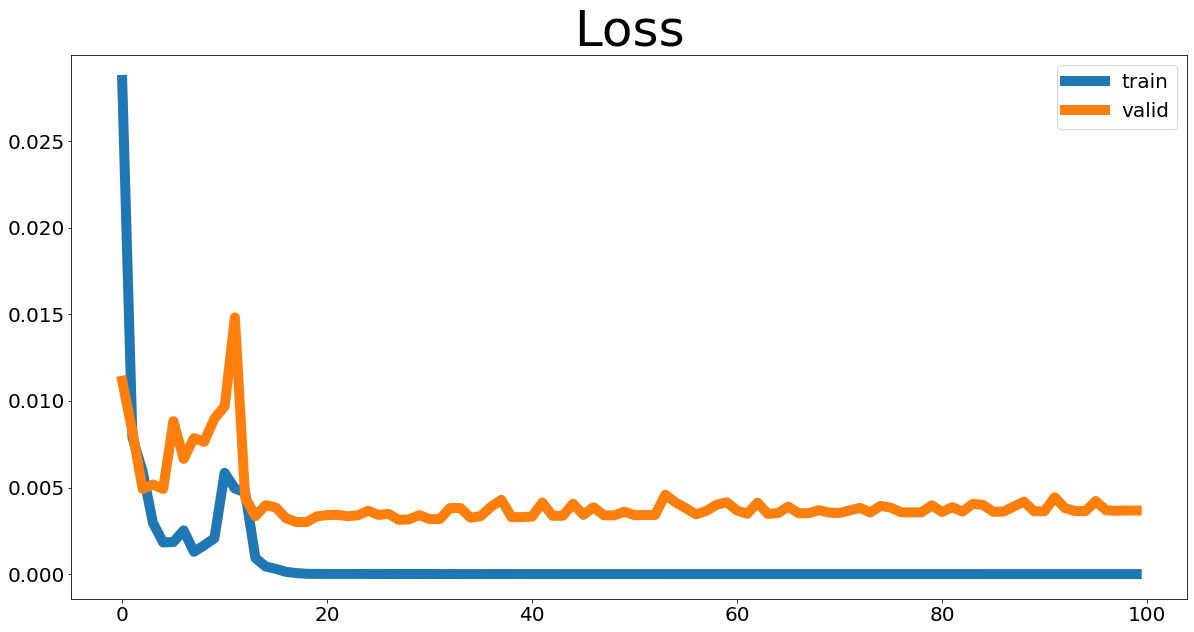

In [46]:
plt.figure(figsize=(20, 10))
plt.rcParams["font.size"] = 20
plt.title("Loss", fontsize=50)
plt.plot(loss_list[0], label="train", linewidth = 10.0)
plt.plot(loss_list[1], label="valid", linewidth = 10.0)
plt.legend()

plt.savefig("loss_figure.png")

plt.show()

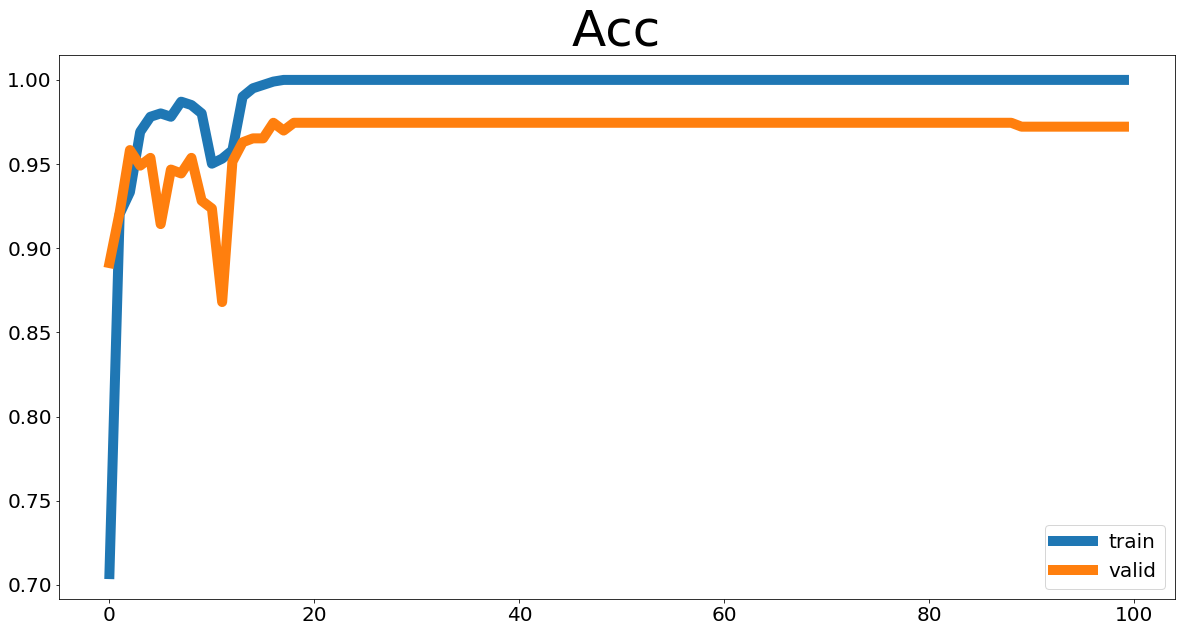

In [45]:
plt.figure(figsize=(20, 10))
plt.rcParams["font.size"] = 20
plt.title("Acc", fontsize=50)
plt.plot(acc_list[0], label="train", linewidth = 10.0)
plt.plot(acc_list[1], label="valid", linewidth = 10.0)
plt.legend()
plt.savefig("acc_figure.png")
plt.show()

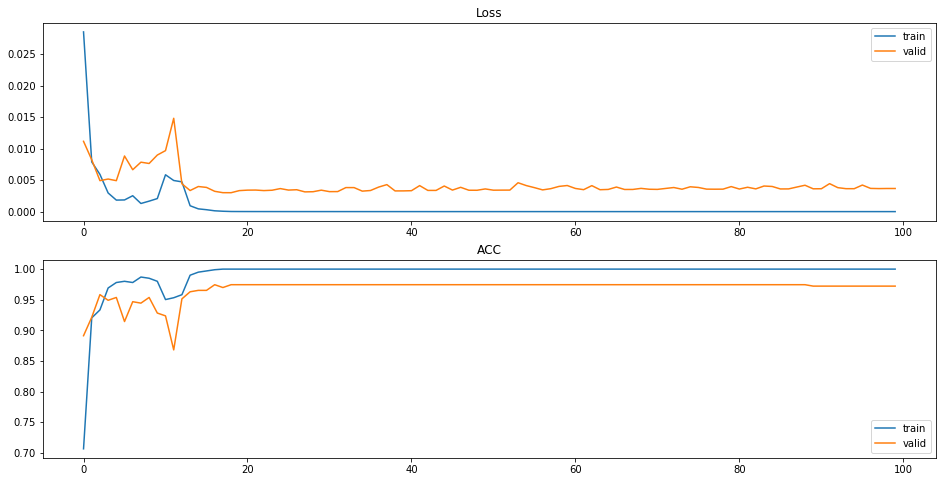

In [14]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(loss_list[0], label="train")
plt.plot(loss_list[1], label="valid")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("ACC")
plt.plot(acc_list[0], label="train")
plt.plot(acc_list[1], label="valid")
plt.legend()

plt.show()

# モデルの保存

In [186]:
#====== 保存 =======
torch.save(model.state_dict(), "model.pth")

## モデルのロード

In [21]:
model = NNNet(64)
#====== ロード =======
model.load_state_dict(torch.load("model.pth", map_location=device))

<All keys matched successfully>

# 検証

In [22]:
def prediction(test_loader):
    pred_list = []
    model.eval()
    with torch.no_grad():
        for images in test_loader:
            images = images[0].to(device)
            outputs = model.forward(images)
            _, pred = torch.max(outputs.data, 1)
            pred_list.append(pred.item())
    return pred_list

In [ ]:
model.eval()

with torch.no_grad():
    outputs = model.forward(images)
            

In [23]:
pred = prediction(test_loader)

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(pred, y_test)

0.9944444444444445

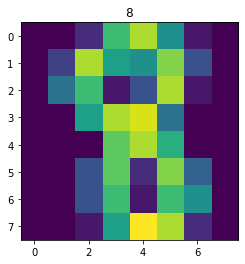

In [28]:
for i, image in enumerate(test_loader):
    plt.title(pred[i])
    plt.imshow(image[0].reshape(8,8))
    plt.show()
    break